# Tarea Final

In [496]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from Paquetes.HelperFunctions import violin_plot_numeric, null_percentage, value_counts_all_cols
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, RepeatedStratifiedKFold
import lightgbm as lgb
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, classification_report

# %matplotlib notebook

# https://www.kaggle.com/competitions/playground-series-s3e26/data?select=train.csv
# Load Dataset
df = pd.read_csv('data/train.csv')
df.head()


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [497]:
from sklearn.model_selection import train_test_split

# Drop ID column
df.drop(columns=['id'], inplace=True)

# Use train_test_split to split the DataFrame
train_df, test_df = train_test_split(df, test_size=0.3)


## EDA

In [498]:
train_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
5300,2797,Placebo,19025,F,N,N,N,N,0.8,414.0,3.23,77.0,1015.0,97.65,158.0,493.0,9.9,2.0,D
3406,1786,D-penicillamine,25329,F,N,Y,N,N,0.7,248.0,3.61,24.0,642.0,57.35,107.0,280.0,10.6,4.0,C
3428,799,Placebo,27398,F,N,Y,N,N,3.6,374.0,3.79,13.0,2115.0,128.65,135.0,322.0,9.8,4.0,C
2365,980,D-penicillamine,18713,F,N,Y,Y,N,11.4,374.0,3.56,140.0,979.0,128.65,100.0,266.0,12.0,3.0,D
7476,321,Placebo,19619,F,N,Y,Y,N,0.8,259.0,4.04,46.0,671.0,79.05,124.0,124.0,12.0,4.0,D


In [499]:
train_df.shape

(5533, 19)

In [500]:
test_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
3306,597,D-penicillamine,15574,F,N,Y,N,N,3.4,1092.0,3.07,231.0,2374.0,130.20,432.0,214.0,11.0,3.0,D
4236,2797,Placebo,18719,F,N,N,N,N,1.0,364.0,3.65,38.0,1787.0,170.50,90.0,349.0,10.8,2.0,C
5449,737,D-penicillamine,14558,F,N,Y,N,N,3.3,310.0,3.60,121.0,1536.0,111.60,231.0,298.0,9.8,3.0,CL
2926,1481,D-penicillamine,18302,F,N,Y,N,N,1.0,219.0,3.85,67.0,640.0,145.00,108.0,95.0,10.7,3.0,C
251,1832,Placebo,12258,F,N,N,Y,N,1.3,342.0,3.74,73.0,1692.0,116.25,63.0,306.0,9.5,3.0,C


In [501]:
test_df.shape

(2372, 19)

In [502]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5533 entries, 5300 to 7022
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5533 non-null   int64  
 1   Drug           5533 non-null   object 
 2   Age            5533 non-null   int64  
 3   Sex            5533 non-null   object 
 4   Ascites        5533 non-null   object 
 5   Hepatomegaly   5533 non-null   object 
 6   Spiders        5533 non-null   object 
 7   Edema          5533 non-null   object 
 8   Bilirubin      5533 non-null   float64
 9   Cholesterol    5533 non-null   float64
 10  Albumin        5533 non-null   float64
 11  Copper         5533 non-null   float64
 12  Alk_Phos       5533 non-null   float64
 13  SGOT           5533 non-null   float64
 14  Tryglicerides  5533 non-null   float64
 15  Platelets      5533 non-null   float64
 16  Prothrombin    5533 non-null   float64
 17  Stage          5533 non-null   float64
 18  Status    

In [503]:
# # Displays the total number of null values per column and the % of those within the column of the provided DataFrame
# # In case a col name is parsed as a parameter, only that column will be printed
# def null_percentage(df: pd.DataFrame, col: str = None):
#     total_rows = len(df)
#     df_cols = df.columns
#     if col in df_cols:
#         null_count = df[col].isnull().sum()
#         percentage_null = (null_count / total_rows) * 100
#         print(f"{col}: total -> {null_count}, percentage -> {percentage_null:.2f}%")
#     elif (col not in df_cols) & (col is not None):
#         print(f"Column \"{col}\" not in Dataframe")
#     else:
#         for col in df.columns:
#             null_count = df[col].isnull().sum()
#             percentage_null = (null_count / total_rows) * 100
#             print(f"{col}: total -> {null_count}, percentage -> {percentage_null:.2f}%")

In [504]:
null_percentage(train_df)

N_Days: total -> 0, percentage -> 0.00%
Drug: total -> 0, percentage -> 0.00%
Age: total -> 0, percentage -> 0.00%
Sex: total -> 0, percentage -> 0.00%
Ascites: total -> 0, percentage -> 0.00%
Hepatomegaly: total -> 0, percentage -> 0.00%
Spiders: total -> 0, percentage -> 0.00%
Edema: total -> 0, percentage -> 0.00%
Bilirubin: total -> 0, percentage -> 0.00%
Cholesterol: total -> 0, percentage -> 0.00%
Albumin: total -> 0, percentage -> 0.00%
Copper: total -> 0, percentage -> 0.00%
Alk_Phos: total -> 0, percentage -> 0.00%
SGOT: total -> 0, percentage -> 0.00%
Tryglicerides: total -> 0, percentage -> 0.00%
Platelets: total -> 0, percentage -> 0.00%
Prothrombin: total -> 0, percentage -> 0.00%
Stage: total -> 0, percentage -> 0.00%
Status: total -> 0, percentage -> 0.00%


* No null values in the training set

### Numerical Cols

In [505]:
numeric_cols = train_df.select_dtypes(include='number')
print(len(numeric_cols.columns))

12


In [506]:
print(type(numeric_cols))

<class 'pandas.core.frame.DataFrame'>


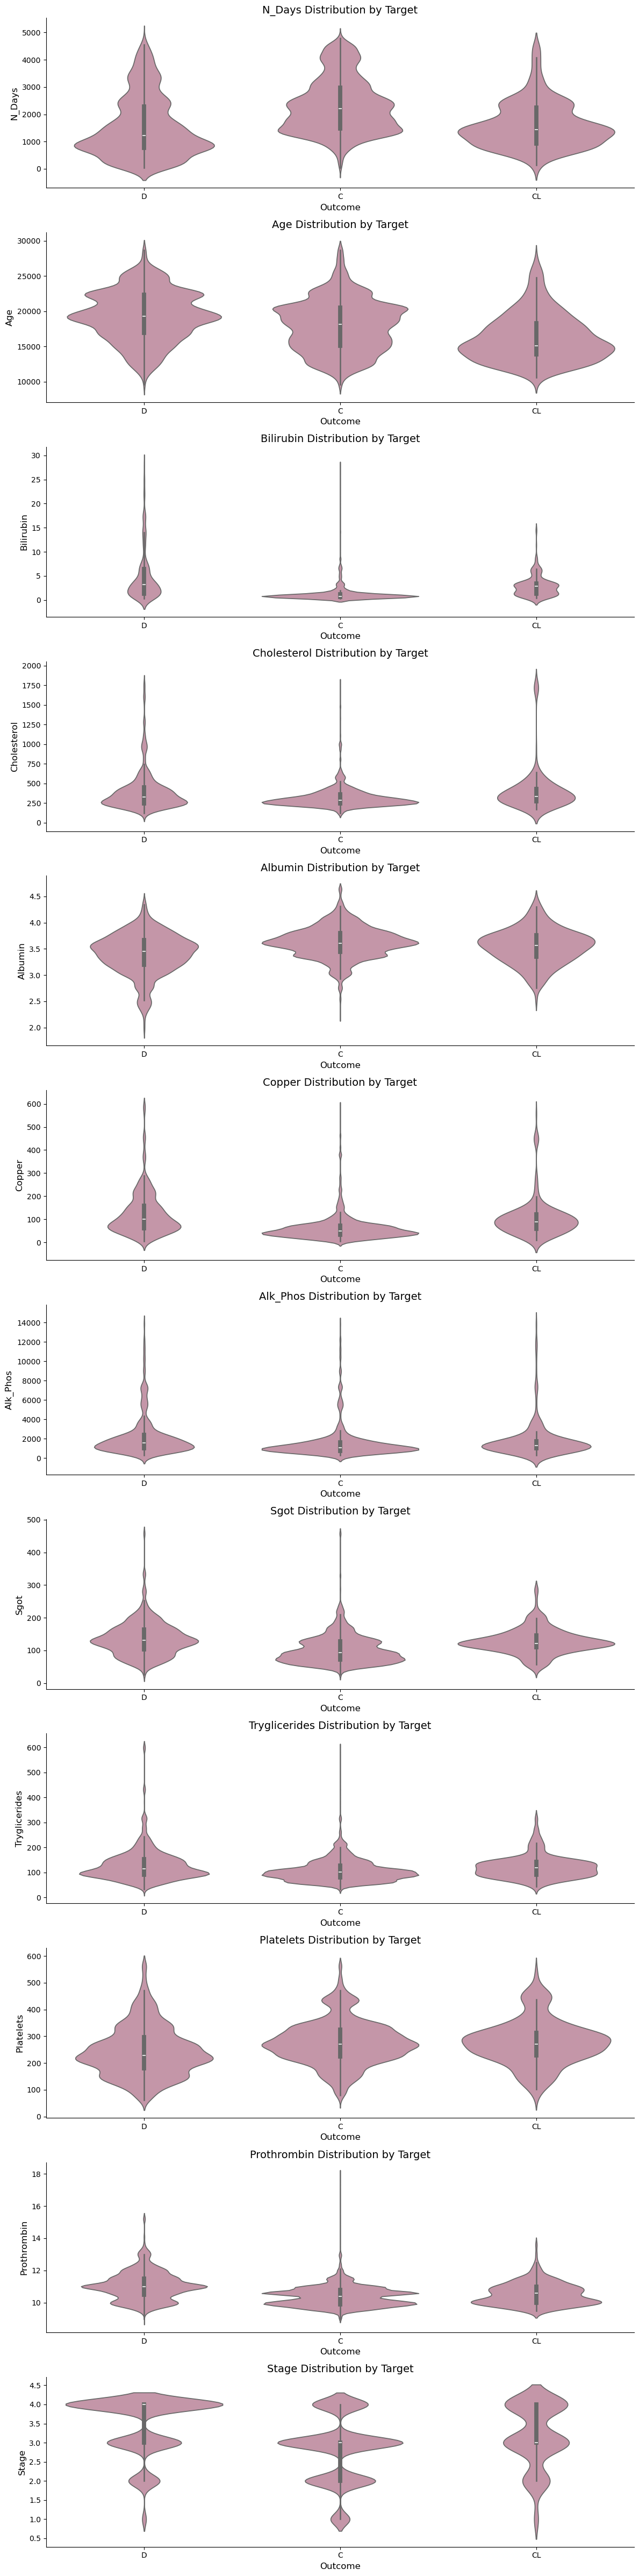

In [507]:
violin_plot_numeric(df, numeric_cols)

### Categorical Columns

In [508]:
cat_cols = train_df.select_dtypes(include='object')
cat_cols

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
5300,Placebo,F,N,N,N,N,D
3406,D-penicillamine,F,N,Y,N,N,C
3428,Placebo,F,N,Y,N,N,C
2365,D-penicillamine,F,N,Y,Y,N,D
7476,Placebo,F,N,Y,Y,N,D
...,...,...,...,...,...,...,...
7183,Placebo,F,N,Y,Y,N,D
2405,D-penicillamine,F,N,Y,N,N,C
490,Placebo,F,N,N,N,S,C
5989,D-penicillamine,F,N,N,N,N,C


In [509]:
value_counts_all_cols(cat_cols)

Value Counts for : Drug
Placebo            2823
D-penicillamine    2710
Name: count, dtype: int64

Value Counts for : Sex
F    5135
M     398
Name: count, dtype: int64

Value Counts for : Ascites
N    5267
Y     266
Name: count, dtype: int64

Value Counts for : Hepatomegaly
Y    2803
N    2730
Name: count, dtype: int64

Value Counts for : Spiders
N    4193
Y    1340
Name: count, dtype: int64

Value Counts for : Edema
N    5016
S     280
Y     237
Name: count, dtype: int64

Value Counts for : Status
C     3516
D     1824
CL     193
Name: count, dtype: int64



* Drug: One-Hot Encoding
* Sex: Label encoding
* Ascites: Label Encoding
* Hepatomegaly: Label Encoding
* Spiders: Label Encoding
* Edema: One-Hot Encoding
* Status: Label Encoding

## One-Hot Encoding

In [510]:
from Paquetes.HelperFunctions import one_hot_encoding
one_hot_cols = ['Edema']

train_df = one_hot_encoding(train_df, one_hot_cols)
test_df = one_hot_encoding(test_df, one_hot_cols)

In [511]:
train_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y
5300,2797,Placebo,19025,F,N,N,N,0.8,414.0,3.23,77.0,1015.0,97.65,158.0,493.0,9.9,2.0,D,True,False,False
3406,1786,D-penicillamine,25329,F,N,Y,N,0.7,248.0,3.61,24.0,642.0,57.35,107.0,280.0,10.6,4.0,C,True,False,False
3428,799,Placebo,27398,F,N,Y,N,3.6,374.0,3.79,13.0,2115.0,128.65,135.0,322.0,9.8,4.0,C,True,False,False
2365,980,D-penicillamine,18713,F,N,Y,Y,11.4,374.0,3.56,140.0,979.0,128.65,100.0,266.0,12.0,3.0,D,True,False,False
7476,321,Placebo,19619,F,N,Y,Y,0.8,259.0,4.04,46.0,671.0,79.05,124.0,124.0,12.0,4.0,D,True,False,False


## Label Encoding

In [512]:
le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
value_counts_all_cols(train_df, le_cols)

Value Counts for : Drug
Placebo            2823
D-penicillamine    2710
Name: count, dtype: int64

Value Counts for : Sex
F    5135
M     398
Name: count, dtype: int64

Value Counts for : Ascites
N    5267
Y     266
Name: count, dtype: int64

Value Counts for : Hepatomegaly
Y    2803
N    2730
Name: count, dtype: int64

Value Counts for : Spiders
N    4193
Y    1340
Name: count, dtype: int64

Value Counts for : Status
C     3516
D     1824
CL     193
Name: count, dtype: int64



In [513]:
from Paquetes.HelperFunctions import label_encoding


le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
cols_dict = {'Drug': {'D-penicillamine': 0, 'Placebo': 1}, 'Sex': {"F":0,"M":1}, 'Ascites':{'N':0,'Y':1}, 'Hepatomegaly': {'N':0,'Y':1}, 'Spiders': {'N':0,'Y':1}, 'Status': {'C':0,'D':1,'CL':2} }
label_encoding(train_df, le_cols, cols_dict)
label_encoding(test_df, le_cols, cols_dict)

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y
3306,597,0,15574,0,0,1,0,3.4,1092.0,3.07,231.0,2374.0,130.20,432.0,214.0,11.0,3.0,2,True,False,False
4236,2797,1,18719,0,0,0,0,1.0,364.0,3.65,38.0,1787.0,170.50,90.0,349.0,10.8,2.0,0,True,False,False
5449,737,0,14558,0,0,1,0,3.3,310.0,3.60,121.0,1536.0,111.60,231.0,298.0,9.8,3.0,1,True,False,False
2926,1481,0,18302,0,0,1,0,1.0,219.0,3.85,67.0,640.0,145.00,108.0,95.0,10.7,3.0,0,True,False,False
251,1832,1,12258,0,0,0,1,1.3,342.0,3.74,73.0,1692.0,116.25,63.0,306.0,9.5,3.0,0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7212,2583,0,19540,0,0,0,0,0.3,233.0,4.08,20.0,622.0,66.65,68.0,358.0,9.9,2.0,2,True,False,False
137,2583,0,20233,0,0,1,0,0.7,226.0,3.90,13.0,9066.8,72.85,62.0,563.0,11.6,4.0,2,True,False,False
6575,2468,1,12557,0,0,0,0,0.6,266.0,3.65,27.0,1083.0,102.30,102.0,239.0,10.2,3.0,0,True,False,False
5137,2272,1,20352,0,0,1,1,2.0,204.0,3.62,58.0,794.0,43.40,126.0,326.0,10.6,4.0,0,True,False,False


In [514]:
le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
value_counts_all_cols(train_df, le_cols)

print(len(train_df))

Value Counts for : Drug
1    2823
0    2710
Name: count, dtype: int64

Value Counts for : Sex
0    5135
1     398
Name: count, dtype: int64

Value Counts for : Ascites
0    5267
1     266
Name: count, dtype: int64

Value Counts for : Hepatomegaly
1    2803
0    2730
Name: count, dtype: int64

Value Counts for : Spiders
0    4193
1    1340
Name: count, dtype: int64

Value Counts for : Status
0    3516
2    1824
1     193
Name: count, dtype: int64

5533


In [515]:
test_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y
3306,597,0,15574,0,0,1,0,3.4,1092.0,3.07,231.0,2374.0,130.20,432.0,214.0,11.0,3.0,2,True,False,False
4236,2797,1,18719,0,0,0,0,1.0,364.0,3.65,38.0,1787.0,170.50,90.0,349.0,10.8,2.0,0,True,False,False
5449,737,0,14558,0,0,1,0,3.3,310.0,3.60,121.0,1536.0,111.60,231.0,298.0,9.8,3.0,1,True,False,False
2926,1481,0,18302,0,0,1,0,1.0,219.0,3.85,67.0,640.0,145.00,108.0,95.0,10.7,3.0,0,True,False,False
251,1832,1,12258,0,0,0,1,1.3,342.0,3.74,73.0,1692.0,116.25,63.0,306.0,9.5,3.0,0,True,False,False


In [516]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5533 entries, 5300 to 7022
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5533 non-null   int64  
 1   Drug           5533 non-null   int64  
 2   Age            5533 non-null   int64  
 3   Sex            5533 non-null   int64  
 4   Ascites        5533 non-null   int64  
 5   Hepatomegaly   5533 non-null   int64  
 6   Spiders        5533 non-null   int64  
 7   Bilirubin      5533 non-null   float64
 8   Cholesterol    5533 non-null   float64
 9   Albumin        5533 non-null   float64
 10  Copper         5533 non-null   float64
 11  Alk_Phos       5533 non-null   float64
 12  SGOT           5533 non-null   float64
 13  Tryglicerides  5533 non-null   float64
 14  Platelets      5533 non-null   float64
 15  Prothrombin    5533 non-null   float64
 16  Stage          5533 non-null   float64
 17  Status         5533 non-null   int64  
 18  Edema_N   

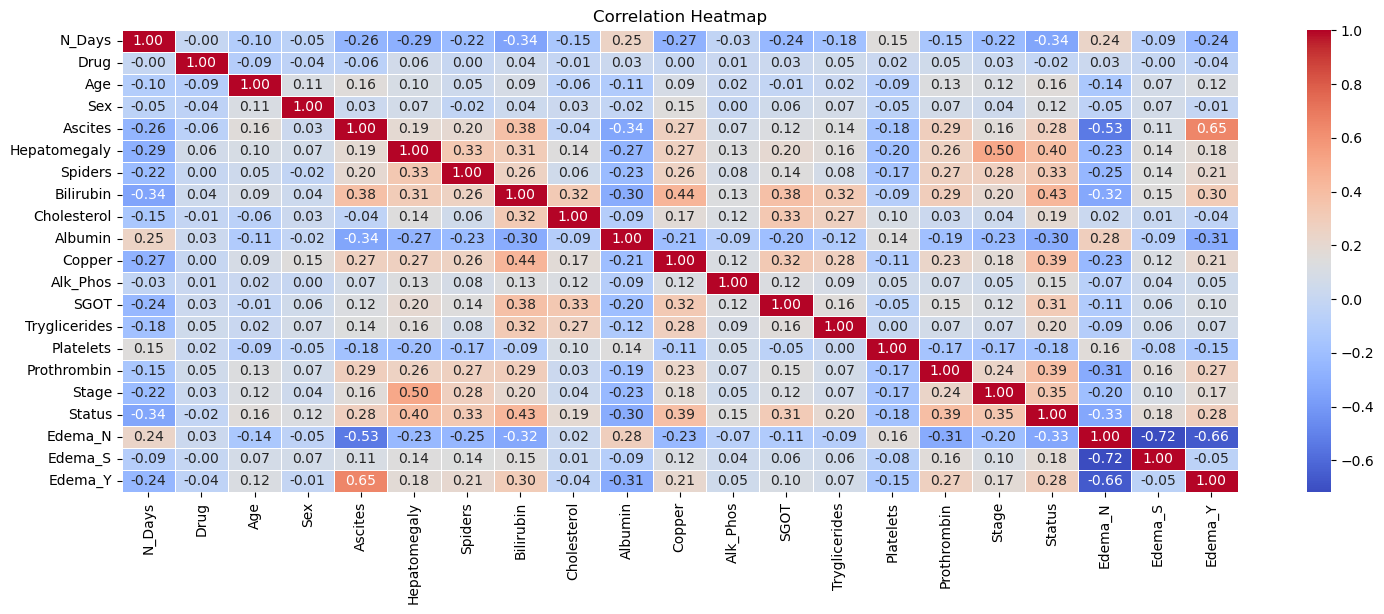

In [517]:
from Paquetes.HelperFunctions import corr_heatmap

corr = corr_heatmap(train_df)

In [518]:
# Possible Mapping dict
mapping_dicts = {
    'Drug': {'D-penicillamine': 0, 'Placebo': 1},
    'Sex': {'M': 0, 'F': 1},
    'Ascites': {'N': 0, 'Y': 1},
    'Hepatomegaly': {'N': 0, 'Y': 1},
    'Spiders': {'N': 0, 'Y': 1},
    'Edema': {'N': 0, 'Y': 1, 'S': 2},
    'Status': {'D': 0, 'C': 1, 'CL': 2},
}

In [519]:
LABEL = "Status"
CAT_FEATS = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
NUM_FEATS = [x for x in train_df.columns if x not in CAT_FEATS and x != LABEL]

In [520]:

class DiagnosisDateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diagnosis_Date'] = X['Age'] - X['N_Days']
        return X
    
class AgeYearsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Age_Years'] = round(X['Age'] / 365.25).astype("int16")
        return X

class AgeGroupsTransformer(BaseEstimator, TransformerMixin):
    """Older people might be hit harder (interaction) by health issues. Also can cover lifestyle influences, i.e.
    alcohol consumption etc."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Use years from above, min=26, max=78
        X['Age_Group'] = pd.cut(X['Age_Years'], bins=[19, 29, 49, 64, 99], labels = [0, 1, 2, 3]).astype('int16')
        return X

class BilirubinAlbuminTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Bilirubin_Albumin'] = X['Bilirubin'] * X['Albumin']
        return X

class DrugEffectivenessTransformer(BaseEstimator, TransformerMixin):
    # Placeholder concept, assuming 'Bilirubin' improvement is a measure of effectiveness
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Drug_Effectiveness'] = X['Drug'] * X['Bilirubin']
        return X

class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    # From data set explanations above let's add all the "bad" symptoms
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
        symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        X['Symptom_Score'] = X[symptom_columns].sum(axis=1)
        return X
    
class SymptomCatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        self.encoder = OneHotEncoder(handle_unknown='ignore')

    def fit(self, X, y=None):
        X_copy = X.copy()
        symptom_scores = X_copy[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        self.encoder.fit(symptom_scores.values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_transformed = X.copy()
        symptom_scores = X_transformed[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        encoded_features = self.encoder.transform(symptom_scores.values.reshape(-1, 1)).toarray().astype("int8")
        encoded_feature_names = self.encoder.get_feature_names_out(input_features=['Symptom_Score'])
        # Drop the original symptom columns and add the new encoded features
        # X_transformed.drop(columns=self.symptom_columns, inplace=True)
        X_transformed[encoded_feature_names] = pd.DataFrame(encoded_features, index=X_transformed.index)
        
        return X_transformed


class LiverFunctionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        liver_columns = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT']
        X['Liver_Function_Index'] = X[liver_columns].mean(axis=1)
        return X

class RiskScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Risk_Score'] = X['Bilirubin'] + X['Albumin'] - X['Alk_Phos']
        return X

class TimeFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diag_Year'] = (X['N_Days'] / 365).astype(int)
        X['Diag_Month'] = ((X['N_Days'] % 365) / 30).astype(int)
        return X
    
class ScalingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_feats = NUM_FEATS + ['Diagnosis_Date', 'Age_Years', 'Bilirubin_Albumin', 'Drug_Effectiveness', 
                                      'Symptom_Score', 'Liver_Function_Index', 'Risk_Score', 'Diag_Year', 'Diag_Month']

    def fit(self, X, y=None):
        self.scaler.fit(X[self.num_feats])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.num_feats] = self.scaler.transform(X_scaled[self.num_feats])
        return X_scaled

# Define the pipeline
pipeline = Pipeline([
    ('diagnosis_date', DiagnosisDateTransformer()),
    ('age_years', AgeYearsTransformer()),
    ('age_groups', AgeGroupsTransformer()),
    ('bilirubin_albumin', BilirubinAlbuminTransformer()),
    ('drug_effectiveness', DrugEffectivenessTransformer()),
    ('symptom_score', SymptomScoreTransformer()),
    ('symptom_cat_score', SymptomCatTransformer()),
    ('liver_function', LiverFunctionTransformer()),
    ('risk_score', RiskScoreTransformer()),
    ('time_features', TimeFeaturesTransformer()),
    #('scaling', ScalingTransformer()),
    # ... ?
])

# Apply the pipeline to your dataframes
train_df_mod = pipeline.fit_transform(train_df)
test_df_mod = pipeline.transform(test_df)
train_df_mod['Symptom_Score'] = pd.to_numeric(train_df_mod['Symptom_Score'], errors='coerce')
test_df_mod['Symptom_Score'] = pd.to_numeric(test_df_mod['Symptom_Score'], errors='coerce')

# Update the CAT_FEATS
CAT_FEATS = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage', #old
             'Age_Group', 'Symptom_Score'] # new 
# Update the NUM_FEATS ????

In [521]:
train_df_mod.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y,Diagnosis_Date,Age_Years,Age_Group,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Symptom_Score_000FalseFalseTrue,Symptom_Score_000FalseTrueFalse,Symptom_Score_000TrueFalseFalse,Symptom_Score_001FalseFalseTrue,Symptom_Score_001FalseTrueFalse,Symptom_Score_001TrueFalseFalse,Symptom_Score_010FalseFalseTrue,Symptom_Score_010FalseTrueFalse,Symptom_Score_010TrueFalseFalse,Symptom_Score_011FalseFalseTrue,Symptom_Score_011FalseTrueFalse,Symptom_Score_011TrueFalseFalse,Symptom_Score_100FalseFalseTrue,Symptom_Score_100FalseTrueFalse,Symptom_Score_100TrueFalseFalse,Symptom_Score_101FalseFalseTrue,Symptom_Score_101FalseTrueFalse,Symptom_Score_101TrueFalseFalse,Symptom_Score_110FalseFalseTrue,Symptom_Score_110FalseTrueFalse,Symptom_Score_110TrueFalseFalse,Symptom_Score_111FalseFalseTrue,Symptom_Score_111FalseTrueFalse,Symptom_Score_111TrueFalseFalse,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
5300,2797,1,19025,0,0,0,0,0.8,414.0,3.23,77.0,1015.0,97.65,158.0,493.0,9.9,2.0,2,True,False,False,16228,52,2,2.584,0.8,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,279.1700,-1010.97,7,8
3406,1786,0,25329,0,0,1,0,0.7,248.0,3.61,24.0,642.0,57.35,107.0,280.0,10.6,4.0,0,True,False,False,23543,69,3,2.527,0.0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,175.9150,-637.69,4,10
3428,799,1,27398,0,0,1,0,3.6,374.0,3.79,13.0,2115.0,128.65,135.0,322.0,9.8,4.0,0,True,False,False,26599,75,3,13.644,3.6,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,562.7600,-2107.61,2,2
2365,980,0,18713,0,0,1,1,11.4,374.0,3.56,140.0,979.0,128.65,100.0,266.0,12.0,3.0,2,True,False,False,17733,51,2,40.584,0.0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,280.6525,-964.04,2,8
7476,321,1,19619,0,0,1,1,0.8,259.0,4.04,46.0,671.0,79.05,124.0,124.0,12.0,4.0,2,True,False,False,19298,54,2,3.232,0.8,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,188.7225,-666.16,0,10


In [522]:
def tsne_with_feature_selection_and_pca(data, num_feats, target_column, n_components=2, top_n_features=10, pca_components=None):
    """
    Select top features based on feature importance, optionally apply PCA, and then use t-SNE for visualization.

    Parameters:
    data (DataFrame): The input data.
    num_feats (list): List of numerical feature column names.
    target_column (str): The name of the target column.
    n_components (int): Number of dimensions for t-SNE (2 or 3). Default is 2.
    top_n_features (int): Number of top features to select based on importance. Default is 10.
    pca_components (int or None): Number of PCA components to retain before applying t-SNE. If None, PCA is not applied.
    """
    
    global label_encoder
    
    # Standardizing the numerical features
    scaler = StandardScaler()
    numerical_data_scaled = scaler.fit_transform(data[num_feats])

    # Random Forest for feature importances
    rf = RandomForestClassifier(random_state=42)
    rf.fit(numerical_data_scaled, data[target_column])
    importances = rf.feature_importances_

    # Selecting top_n_features
    indices = np.argsort(importances)[-top_n_features:]
    selected_features = [num_feats[i] for i in indices]

    # Data for t-SNE
    tsne_data = numerical_data_scaled[:, indices]

    # Optionally applying PCA
    if pca_components is not None and pca_components < len(selected_features):
        pca = PCA(n_components=pca_components)
        tsne_data = pca.fit_transform(tsne_data)

    # Applying t-SNE
    tsne = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(tsne_data)

    # Creating a DataFrame for the t-SNE results
    tsne_df = pd.DataFrame(tsne_results, columns=[f'Component {i+1}' for i in range(n_components)])
    tsne_df[target_column] = label_encoder.inverse_transform(data[target_column].values)

    # Visualizing using Plotly
    if n_components == 3:
        fig = px.scatter_3d(tsne_df, x='Component 1', y='Component 2', z='Component 3', color=target_column)
    else:
        fig = px.scatter(tsne_df, x='Component 1', y='Component 2', color=target_column)
    
    fig.update_layout(width=800, height=600)
    fig.show()

train_df_red = train_df_mod
# tsne_with_feature_selection_and_pca(df_train_red, NUM_FEATS, LABEL, n_components=3, top_n_features=10, pca_components=None)

In [523]:
# Features to combine 
# All
#df_train_pca = df_train_mod.drop([LABEL], axis=1)
#df_test_pca = df_test_mod

# Numerical feats
df_train_pca = train_df[NUM_FEATS]
df_test_pca = test_df_mod[NUM_FEATS]

# Some, the feats here are taken iteratively from previous runs
#FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days']
#PCA_FEATS = [c for c in df_train_mod.drop(LABEL, axis=1).columns.values if c not in FEATS]
#df_train_pca = df_train_mod[PCA_FEATS]
#df_test_pca = df_test_mod[PCA_FEATS]

pca = PCA(n_components=10)
df_train_pca = pca.fit_transform(df_train_pca)
df_test_pca = pca.transform(df_test_pca)

print(f"Explained variance per component: {np.round(pca.explained_variance_ratio_, 1)}")

Explained variance per component: [0.7 0.2 0.1 0.  0.  0.  0.  0.  0.  0. ]


In [524]:
eps_expl_var_treshold = 0
n_pcas = np.sum(np.round(pca.explained_variance_ratio_, 3) > eps_expl_var_treshold)
pca_c_names = [f"PCA_{i}" for i in range(n_pcas)]
print(f"PCA column names: {pca_c_names}")
train_df_mod[pca_c_names] = df_train_pca[:,0:n_pcas]
test_df_mod[pca_c_names] = df_test_pca[:,0:n_pcas]

PCA column names: ['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3']


## Model Selection

In [525]:
# All
# FEATS = df_train_mod.drop(LABEL, axis=1).columns.tolist()
# Some
FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 
         'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage', 'Drug', 
         'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y']
# FEATS = FEATS + pca_c_names
# FEATS = sel_feats.tolist()
print(f"Number of feats: {len(FEATS)}")
print(f"Features used: {FEATS}")

# Local optuna optimization test (cross val score: .4129666179319006), 21 FEATS
xgb_params = {'objective': 'multi_logloss', 'early_stopping_rounds': 50, 'max_depth': 9, 'min_child_weight': 8, 'learning_rate': 0.0337716365315986, 'n_estimators': 733, 'subsample': 0.6927955384688348, 'colsample_bytree': 0.1234702658812108, 'reg_alpha': 0.18561628377665318, 'reg_lambda': 0.5565488299127089, 'random_state': 42}

Number of feats: 21
Features used: ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage', 'Drug', 'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y']


In [526]:
# Just use the selected features
df_train_final = train_df_mod[FEATS + [LABEL]]
df_test_final = test_df_mod[FEATS+[LABEL]]

In [527]:
def validate_models(models: list[dict],
                    data: pd.DataFrame, 
                    label=LABEL,
                    n_splits=5,
                    n_repeats=1,
                    seed=43):
    """Run models and test them on validation sets. The optimal parameters 
    should be retrieved from previous runs e.g. GridSearchCV etc."""
    
    # TODO: the model dicts should contain the FEATS (since different FEATS should be used)
    
    train_scores, val_scores = {}, {}
    
    pbar = tqdm(models)
    for model in pbar:
        
        # Model needs to be a dict (before tuple) since I need a mutable datatype
        # to insert the average validation score in the end
        model_str = model["name"]
        model_est = model["model"]
        model_feats = model["feats"]
        
        pbar.set_description(f"Processing {model_str}...")
        
        train_scores[model_str] = []
        val_scores[model_str] = []
    
        # I think I should drop the seed when I blend the models together
        # -> they will be trained on different datasets
        skf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

        for i, (train_idx, val_idx) in enumerate(skf.split(data[model_feats], data[label])):
            pbar.set_postfix_str(f"Fold {i+1}/{n_splits}")
            # Resetting index to ensure valid indices
            train_idx = data[model_feats].index[train_idx]
            val_idx = data[model_feats].index[val_idx]
            X_train, y_train = data[model_feats].loc[train_idx], data[label].loc[train_idx]
            # X_train, y_train = data.loc[train_idx, model_feats], data.loc[train_idx, label]
            X_val, y_val = data[model_feats].loc[val_idx], data[label].loc[val_idx]
            
            # print(X_train.dtypes)
            if model_str in ["lgb_cl"]:
                callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
                model_est.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=callbacks)
            elif model_str in ["xgb_cl", "cat_cl"]:
                model_est.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)
            elif model_str in ["voting_clf"]:
                pass # TODO: find a solution
            else:
                model_est.fit(X_train, y_train)
                
            train_preds = model_est.predict_proba(X_train[model_feats])
            valid_preds = model_est.predict_proba(X_val[model_feats])
            train_score = log_loss(y_train, train_preds)
            val_score = log_loss(y_val, valid_preds)
            train_scores[model_str].append(train_score)
            val_scores[model_str].append(val_score)
            
            #print(f"{model_str} | Fold {i + 1} | " +
            #      f"Train log_loss: {round(train_score, 4)} | " +
            #      f"Valid log_loss: {round(val_score, 4)}")
        
        model["avg_val_score"] = np.mean(val_scores[model_str])
            
    return models, pd.DataFrame(train_scores), pd.DataFrame(val_scores)

In [528]:
# %%time

xgb_cl = xgb.XGBClassifier(**xgb_params)
rf_cl = RandomForestClassifier()

models = [
    {"name": "xgb_cl", "model": xgb_cl, "feats": FEATS},
    # {"name": "rf_cl", "model": rf_cl, "feats": FEATS}
]

models, train_scores, val_scores = validate_models(models=models, 
                                                   data=df_train_final, 
                                                   n_splits=10,
                                                   n_repeats=1)

Processing xgb_cl...: 100%|██████████| 1/1 [00:19<00:00, 19.68s/it, Fold 10/10]


In [529]:
models
# train_scores
# val_scores

[{'name': 'xgb_cl',
  'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.1234702658812108, device=None,
                early_stopping_rounds=50, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.0337716365315986,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=9, max_leaves=None,
                min_child_weight=8, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=733, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob', ...),
  'feats': ['Platelets',
   'Copper',
   'Alk_Phos',
   'Diagnosis_Date',
   'SGOT',
   'Age',
   'N_Days',
   'Cholesterol',
   'Tryglicerides',


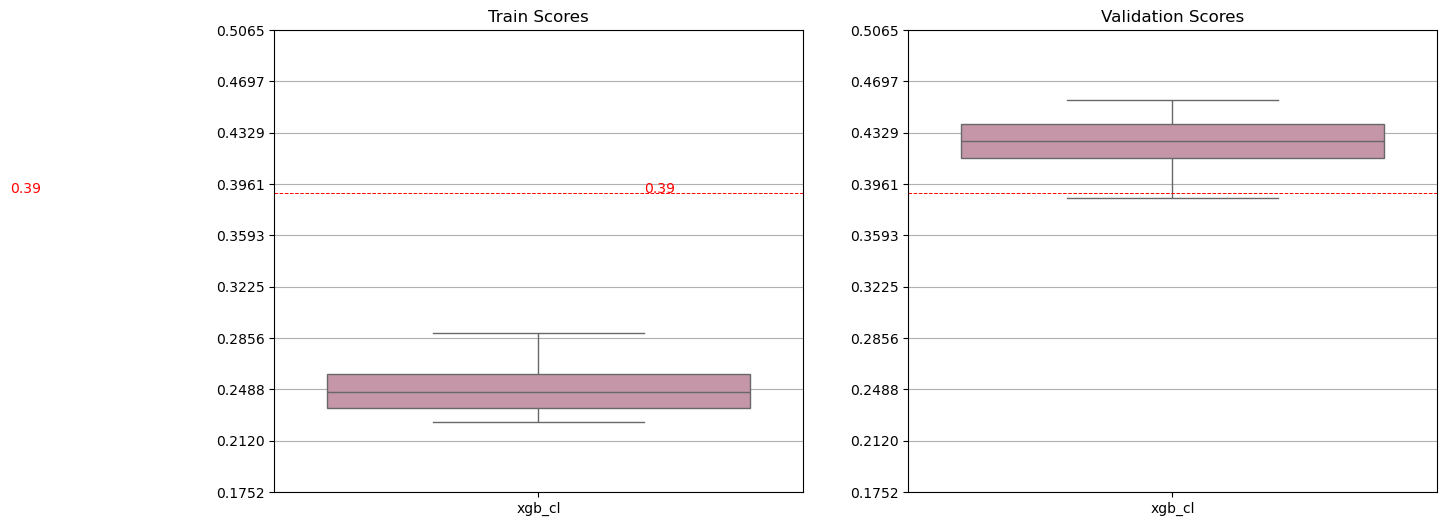

In [530]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

eps = .05
hl = .39
min_score = train_scores.min().min()-eps
max_score = val_scores.max().max()+eps

def calculate_ticks(min_score, max_score, num_ticks=10):
    return np.linspace(min_score, max_score, num_ticks)

ticks = calculate_ticks(min_score, max_score)

_ = sns.boxplot(train_scores, ax=axes[0])
_ = axes[0].set_title('Train Scores')
_ = axes[0].set_ylim(min_score, max_score)
_ = axes[0].set_yticks(ticks)
_ = axes[0].yaxis.grid(True)
_ = axes[0].axhline(y=hl, color='r', linestyle='--', lw=.7)
_ = axes[0].text(-1, hl, f"{hl}", c="red")

_ = sns.boxplot(val_scores, ax=axes[1])
_ = axes[1].set_title('Validation Scores')
_ = axes[1].set_ylim(min_score, max_score)
_ = axes[1].set_yticks(ticks)
_ = axes[1].yaxis.grid(True)
_ = axes[1].axhline(y=hl, color='r', linestyle='--', lw=.7)
_ = axes[1].text(-1, hl, f"{hl}", c="red")

           Train  Validation
count  10.000000   10.000000
mean    0.248853    0.423847
std     0.019363    0.023169
min     0.225223    0.386427
25%     0.235462    0.415060
50%     0.246830    0.427149
75%     0.259835    0.439158
max     0.289590    0.456502


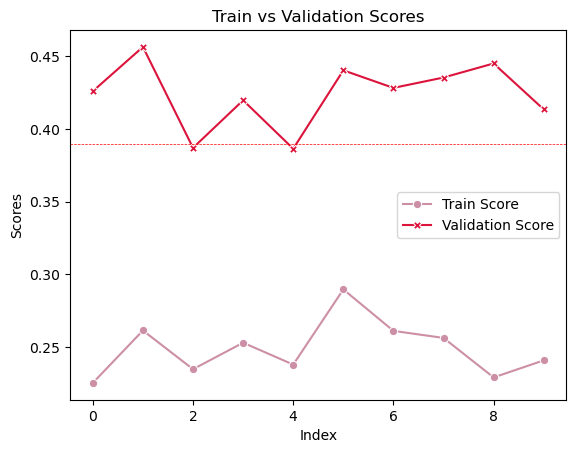

In [531]:

# Print results in DataFrame
model_res = pd.concat([train_scores.describe(), val_scores.describe()], axis=1)
model_res.columns = ['Train', 'Validation']
print(model_res)

# Plot results as lineplot
_ = sns.lineplot(pd.concat([train_scores, val_scores], keys=["Train Score", "Validation Score"], axis=1), markers=True, dashes=False)
plt.axhline(y=0.39, color='r', linestyle='--', lw=.5)
plt.title('Train vs Validation Scores')
plt.xlabel('Index')
plt.ylabel('Scores')
plt.show()

In [532]:
class MyAvgVoting(BaseEstimator, ClassifierMixin):
    """A basic voting method that just averages all estimator predictions and 
    predicts the class with the highest vote."""
    def __init__(self, estimators, weighted=False):
        self.estimators = estimators
        # Whether to average according to validation scores
        self.weighted = weighted

    def fit(self, X, y):
        for _, est in self.estimators:
            est["model"].fit(X, y)
        return self
    
    def create_avg_prob_predictions(self, X):
        predictions = np.array([est["model"].predict_proba(X) for est in self.estimators])
        if self.weighted:
            # Note: we need the inverse of the val_score since lower values are "better"
            weights = [{"name": est["name"], "value": 1/est["avg_val_score"]} for est in self.estimators]
            print(f"Weights are:\n{pd.DataFrame(weights)}")
            return np.average(predictions, axis=0, weights=[w["value"] for w in weights])
        return np.average(predictions, axis=0)
            
    def predict(self, X):
        avg_predictions = self.create_avg_prob_predictions(X)
        return np.argmax(avg_predictions, axis=1)

    def predict_proba(self, X):
        avg_predictions = self.create_avg_prob_predictions(X)
        return avg_predictions

    def score(self, X, y):
        pass

voting_ests = models
voting_clf = MyAvgVoting(voting_ests, weighted=False) 
# no fitting needed

In [533]:
model_fin = models[0]['model']

In [534]:
df_test_final.head()

,Platelets,Copper,Alk_Phos,Diagnosis_Date,SGOT,Age,N_Days,Cholesterol,Tryglicerides,Albumin,Bilirubin,Prothrombin,Symptom_Score,Stage,Drug,Hepatomegaly,Spiders,Sex,Edema_N,Edema_S,Edema_Y,Status
3306,214.0,231.0,2374.0,14977,130.20,15574,597,1092.0,432.0,3.07,3.4,11.0,2,3.0,0,1,0,0,True,False,False,2
4236,349.0,38.0,1787.0,15922,170.50,18719,2797,364.0,90.0,3.65,1.0,10.8,1,2.0,1,0,0,0,True,False,False,0
5449,298.0,121.0,1536.0,13821,111.60,14558,737,310.0,231.0,3.60,3.3,9.8,2,3.0,0,1,0,0,True,False,False,1
2926,95.0,67.0,640.0,16821,145.00,18302,1481,219.0,108.0,3.85,1.0,10.7,2,3.0,0,1,0,0,True,False,False,0
251,306.0,73.0,1692.0,10426,116.25,12258,1832,342.0,63.0,3.74,1.3,9.5,2,3.0,1,0,1,0,True,False,False,0


In [535]:
y_pred_train = model_fin.predict(df_train_final[FEATS])
y_pred_test = model_fin.predict(df_test_final[FEATS])


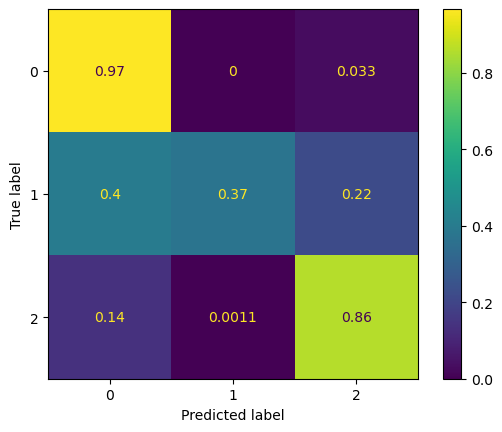

In [536]:

ConfusionMatrixDisplay.from_predictions(df_train_final[LABEL], y_pred_train, normalize='true')
plt.show()


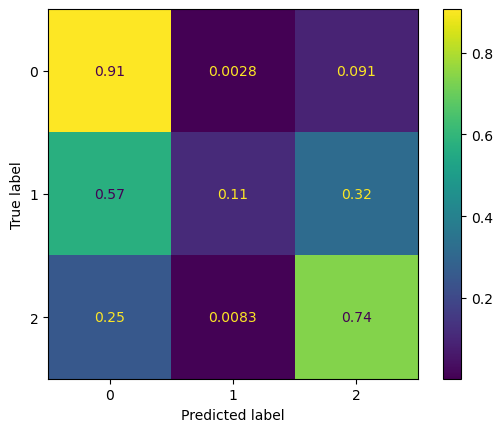

In [537]:
ConfusionMatrixDisplay.from_predictions(df_test_final[LABEL], y_pred_test, normalize='true')
plt.show()

In [538]:
print(f"Clssification report Training: ")
print(classification_report(df_train_final[LABEL],y_pred_train))
print(f"\nClassification Report Testing: ")
print(classification_report(df_test_final[LABEL],y_pred_test))

Clssification report Training: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3516
           1       0.97      0.37      0.54       193
           2       0.91      0.86      0.88      1824

    accuracy                           0.91      5533
   macro avg       0.93      0.73      0.79      5533
weighted avg       0.91      0.91      0.91      5533


Classification Report Testing: 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1449
           1       0.45      0.11      0.18        82
           2       0.80      0.74      0.77       841

    accuracy                           0.82      2372
   macro avg       0.69      0.58      0.60      2372
weighted avg       0.81      0.82      0.81      2372



In [539]:
# Creating Pandas Series for feature importances
rf_feat_importances = pd.Series(rf_cl.feature_importances_, index=df_train_final[FEATS].columns)

# Plotting both feature importances in subplots
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

rf_feat_importances.nlargest(20).plot(kind='barh', title='RF Feature Importances')

plt.tight_layout()
plt.show()
print(f"Total sorted XGBClassifier importances: {rf_feat_importances.nlargest(99).index.tolist()}")

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.